In [1]:
import pandas as pd
import datetime
ts = pd.read_csv('/Users/gabeheim/documents/repos/bender/source files/ADABTC_3m.csv', index_col=False)#.set_index('Open time')
ts['Open time'].divide(10000)
ts['Open time'] = pd.to_datetime(ts['Open time']/1000,unit='s')
ts = ts.set_index('Open time') # Set index


In [51]:
del ts['Close time']
ts.head()

,Open time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades
0,1559952000000,0.04995000,0.04995700,0.04986000,0.04986000,73.40700000,3.66314475,75
1,1559952180000,0.04987300,0.04994000,0.04985600,0.04990200,226.11000000,11.28320546,151
2,1559952360000,0.04990500,0.04997300,0.04985600,0.04993200,129.28300000,6.45180110,161
3,1559952540000,0.04998100,0.05003200,0.04991200,0.05000000,834.47600000,41.71974991,283
4,1559952720000,0.05000500,0.05018900,0.05000100,0.05012400,438.13000000,21.94579034,244


In [35]:
from binance.client import Client
binance = Client("vg1Sdkl5oB09uaSIKrOoRHyl1xTJCtem9UgzpFbjFn40YHrhBRw5Iwztu111Hk9L", "cE8fd8CSEhHXCbrqL8M3BUvxcYiIoJqQTcuCm1o18Xs4S0aAYdrRohAqgbcsxBmn")

In [108]:
kline = binance.get_historical_klines('TRXBTC', Client.KLINE_INTERVAL_3MINUTE, str(datetime.date.today() - datetime.timedelta(1)))

In [114]:
ts = pd.DataFrame(kline, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Can be ignored']).set_index("Open time")
ts['Close'].astype(float)
ts.head()

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Can be ignored
Open time,,,,,,,,,,,
1559952000000,0.00000420,0.00000420,0.00000420,0.00000420,165927.00000000,1559952179999,0.69689340,12,165927.00000000,0.69689340,0
1559952180000,0.00000419,0.00000420,0.00000418,0.00000418,711372.00000000,1559952359999,2.97964915,80,249346.00000000,1.04517128,0
1559952360000,0.00000419,0.00000419,0.00000418,0.00000418,170440.00000000,1559952539999,0.71353747,16,109827.00000000,0.46017513,0
1559952540000,0.00000418,0.00000421,0.00000418,0.00000421,1769987.00000000,1559952719999,7.42960115,75,1694318.00000000,7.11227623,0
1559952720000,0.00000421,0.00000421,0.00000420,0.00000420,139601.00000000,1559952899999,0.58637492,11,7779.00000000,0.03272252,0


In [115]:
del ts['Can be ignored']
del ts['Taker buy base asset volume']
del ts['Taker buy quote asset volume']

In [116]:
from PeakDetect import peakdetect
def supres(df, peak_lookahead=24, min_touches=2, stat_likeness_percent=7.5, bounce_percent=0.1):
    """Support and Resistance Testing
    Identifies support and resistance levels of provided price action data.
    Args:
        low(pandas.Series): A pandas Series of lows from price action data.
        high(pandas.Series): A pandas Series of highs from price action data.
        min_touches(int): Minimum # of touches for established S&R.
        stat_likeness_percent(int/float): Acceptable margin of error for level.
        bounce_percent(int/float): Percent of price action for established bounce.
    
    ** Note **
        If you want to calculate support and resistance without regard for
        candle shadows, pass close values for both low and high.
    Returns:
        sup(float): Established level of support or None (if no level)
        res(float): Established level of resistance or None (if no level)
    """
    # Setting default values for support and resistance to None
    sup = None
    res = None
    
    low = df['Low'].astype(float).values
    high = df['High'].astype(float).values
    close = df['Close'].astype(float).values

#     df.insert(0, 'id', range(0, 0 + len(df)))
    
    # Identifying local high and local low
    maxima = peakdetect.peakdetect(high, lookahead=peak_lookahead)[0]#high.max()
    minima = peakdetect.peakdetect(low, lookahead=peak_lookahead)[1]#low.min()
    
    sup_ary = []
    res_ary = []
    min_ary = []
    max_ary = []
    for i, peak in enumerate(maxima):
        # Calculating distance between max and min (total price movement)
        max = maxima[i][1]
        min = minima[i][1]
        min_ary.append(int(minima[i][0]))
        max_ary.append(int(maxima[i][0]))
        move_range = max - min
        
        # Calculating bounce distance and allowable margin of error for likeness
        move_allowance = move_range * (stat_likeness_percent / 100)
        bounce_distance = move_range * (bounce_percent / 100)
        
        # Test resistance by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for x in range(0, len(high)):
            if abs(max - high[x]) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(max - high[x]) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            res = max
            res_ary.append(res)

        # Test support by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for x in range(0, len(low)):
            if abs(low[x] - min) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(low[x] - min) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            sup = min
            sup_ary.append(sup)
    col = []
    for row in df.iterrows():
#         print(type(row[len(row)-1]),row[len(row)-1][0], row, min_ary)#row[len(row)-1] in min_ary, 
        if float(row[len(row)-1][0]) in min_ary:
            col.append(1)
        elif float(row[len(row)-1][0]) in max_ary:
            col.append(2)
        else:
            col.append(0)
#     col = pd.DataFrame(col, columns=["flag"])
    df['flag'] = pd.Series(col, index=df.index)
#     df = df.join(col)
    buys = df.loc[df['flag'] == 1]
    sells = df.loc[df['flag'] == 2]
    fig, (ax2) = plt.subplots(nrows=1, figsize=(20,6))
    ax2.plot(buys.index, df.loc[buys.index]['Close'], '^', markersize=10, color='g')
    ax2.plot(sells.index, df.loc[sells.index]['Close'], 'v', markersize=10, color='r')
    ax2.plot(df.index, df['Close'], label='Close')
    ax2.set_title("peaks")
    plt.show()
    return sup_ary,res_ary

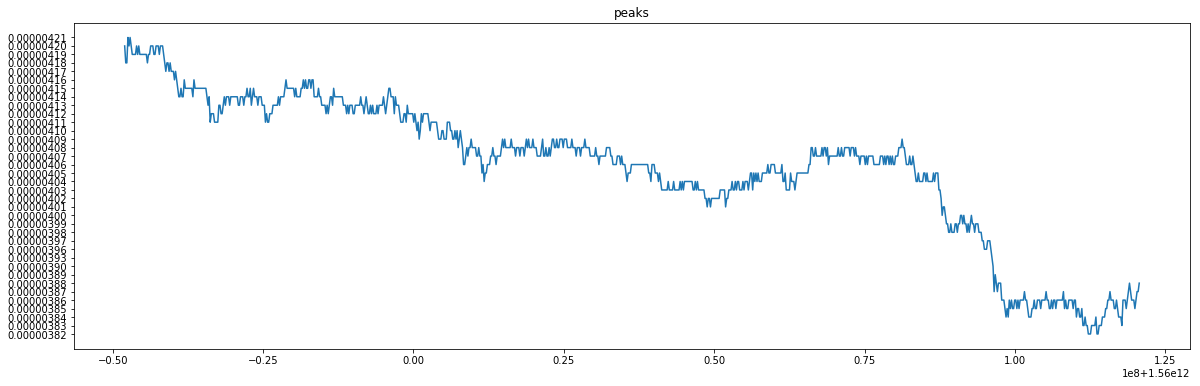

[4.1e-06, 4.03e-06, 4.01e-06] [4.16e-06, 4.1e-06, 4.09e-06]


In [130]:
import talib
from ta import *
import matplotlib.pyplot as plt
# MMI, CBI?, whites reality check

# ALMA seems to be the best representation of the impulse, while the ZMA produces the fastest response with 
#     no overshoot, the Decycler the fastest with some overshoot
#  - MACD bullish crossover
#  - RSI, 

#ADX (ADXR) and DI+/-

# The money flow index (#MFI) measures momentum in security by showing the inflow and outflow of money into security over time. It is volume-weighted RSI. But works differently. The calculation of the MFI is not important. The strategy is simple. 
# When MFI runs above 80 a security is 'overbought' (SELL Signal) while when the indicator is below 20 a security 
#     is 'oversold' (BUY Signal).

# Commodity Channel Indicator (CCI) designed to find cyclical trends in the market and to be used as a bearish 
#     or bullish filter. The CCI is simply an oscillator indicator that moves the majority of the time between +100 
#     and -100. IF CCI is above +100 it is sell signal, but you have to wait how it will react to 0 CCI, the most of 
#     the time it gets support here and continue to rise. Breaking down 0 CCI is sell signal, under -100 CCI is buy 
#     signal.

ts = pd.DataFrame(kline, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Can be ignored']).set_index("Open time")
ts['Close'].astype(float)
ts.head()

del ts['Can be ignored']
del ts['Taker buy base asset volume']
del ts['Taker buy quote asset volume']

# Clean NaN values
ts = utils.dropna(ts)

# Add ta features filling NaN values
# ts = add_all_ta_features(ts, "Open", "High", "Low", "Close", "Volume", fillna=True)
data = ts
data['RSI'] = rsi(data["Close"].astype(float), n=14, fillna=True)
# print(pd.DataFrame({'RSI': data['RSI'], 'close': data['Close']}))
# data = ts.loc['1559952000000':'1559952720000']
supports, resistances = supres(data, peak_lookahead=70) 

print(supports, resistances)

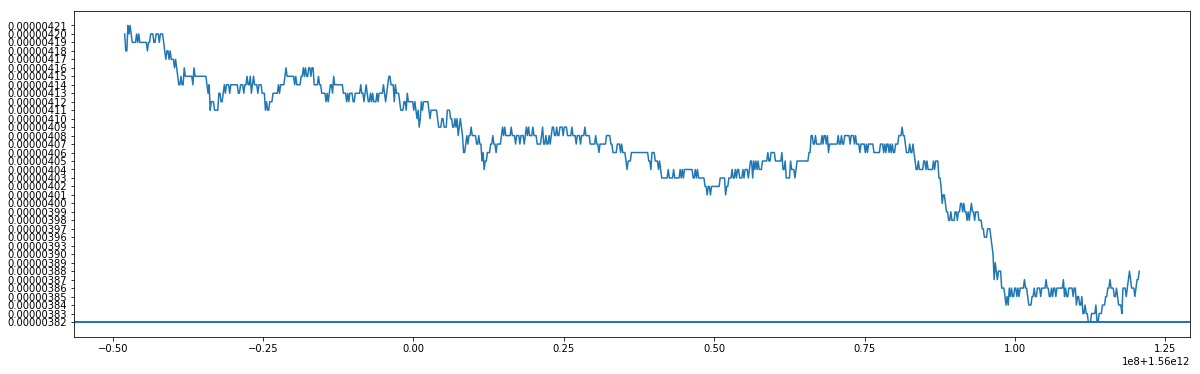

In [131]:
# fig, (ax3) = plt.subplots(nrows=2, figsize=(20,10))
plt.figure(figsize=(20,6))
plt.plot(data.index, data['Close'], label='Close')
# plt.set_title('Close')
plt.figsize=(20,10)
for level in supports:
    if level is not None:
        plt.axhline(y=level)
for level in resistances:
    if level is not None:
        plt.axhline(y=level)

# Add a bit more space between the two plots.
# fig.subplots_adjust(hspace=0.3)
plt.show()

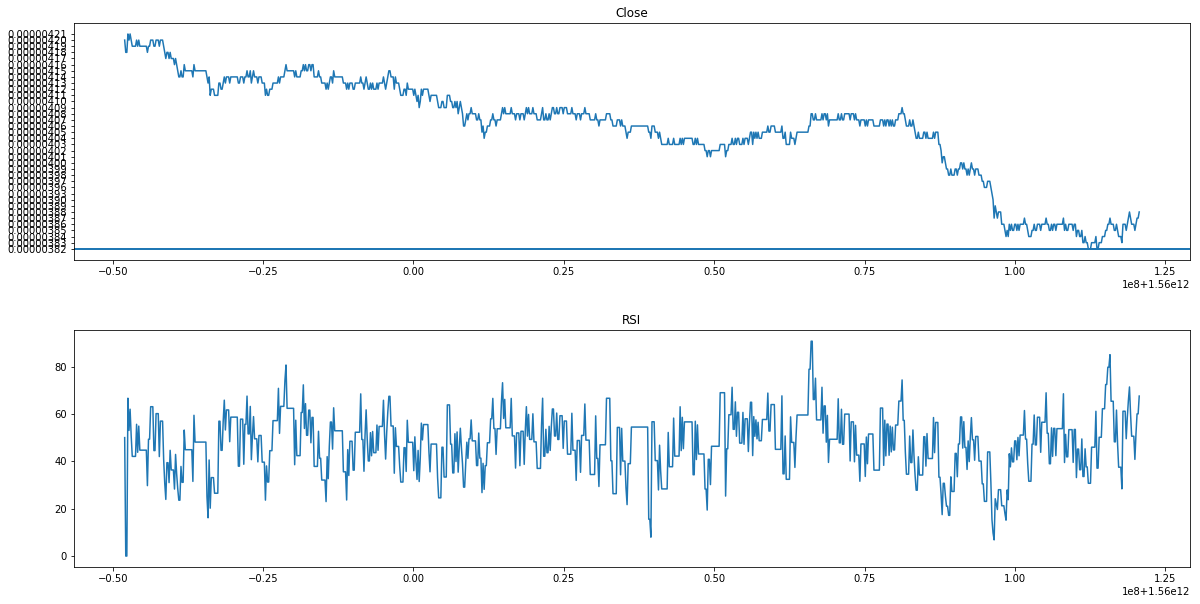

In [134]:
percentage_from_level = 0.11
# Select buying and selling signals: where moving averages cross

levels = supports + resistances

# print(ary)
# ary = pd.DataFrame(ary).set_index(ts.index)
buys_rsi = data.loc[data['RSI'] <= 30]#df['Close'].apply(lambda x: x -  levels < ]#
sells_rsi = data.loc[data['RSI'] >= 70]

# buy_check = [False] * len(buys_rsi['Close'])
# for level in levels:
#     for i, row in enumerate(buys_rsi['Close']):
#         if abs(row - level) < row * percentage_from_level / 100:
#             buy_check[i] = True

#
buy_check = pd.Series(buy_check)
buys_rsi = buys.loc[buy_check.values]
# sell_check = [None] * len(sells)
# 
#     for i, row in enumerate(buys):
#         
#     for i, row in enumerate(sells):
#         ary_sell[i] = (abs(row - level) < row * percentage_from_level / 100)
        
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(20,10))
ax0.plot(buys_rsi.index, data.loc[buys_rsi.index]['Close'], '^', markersize=10, color='g')
# ax0.plot(sells_rsi.index, data.loc[sells_rsi.index]['Close'], 'v', markersize=10, color='r')
ax0.plot(data.index, data['Close'], label='Close')
for level in levels:
    if level is not None:
        ax0.axhline(y=level)
ax0.set_title('Close')
ax1.plot(data.index, data['RSI'], label='RSI')
ax1.set_title('RSI')

# Add a bit more space between the two plots.
fig.subplots_adjust(hspace=0.3)
plt.show()

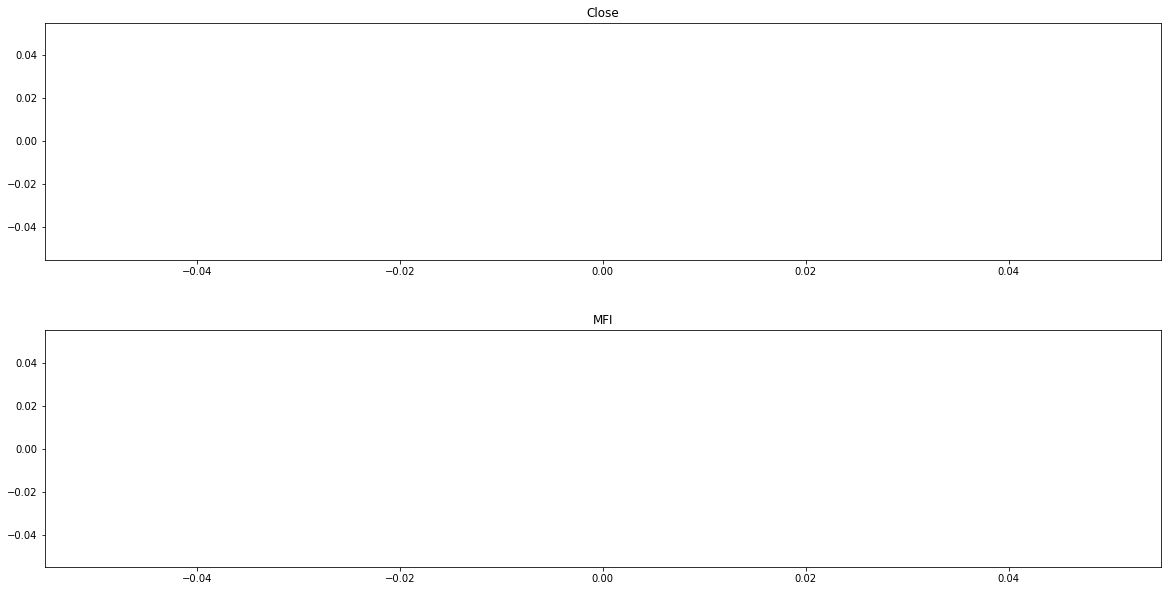

In [135]:
# MMI, CBI?, whites reality check

# ALMA seems to be the best representation of the impulse, while the ZMA produces the fastest response with 
#     no overshoot, the Decycler the fastest with some overshoot
#  - MACD bullish crossover
#  - RSI, 

#ADX (ADXR) and DI+/-

# The money flow index (#MFI) measures momentum in security by showing the inflow and outflow of money into security over time. It is volume-weighted RSI. But works differently. The calculation of the MFI is not important. The strategy is simple. 
# When MFI runs above 80 a security is 'overbought' (SELL Signal) while when the indicator is below 20 a security 
#     is 'oversold' (BUY Signal).

# Commodity Channel Indicator (CCI) designed to find cyclical trends in the market and to be used as a bearish 
#     or bullish filter. The CCI is simply an oscillator indicator that moves the majority of the time between +100 
#     and -100. IF CCI is above +100 it is sell signal, but you have to wait how it will react to 0 CCI, the most of 
#     the time it gets support here and continue to rise. Breaking down 0 CCI is sell signal, under -100 CCI is buy 
#     signal.


# Add ta features filling NaN values
# ts = add_all_ta_features(ts, "Open", "High", "Low", "Close", "Volume", fillna=True)
ts['MFI'] = talib.MFI(ts["High"], ts["Low"], ts["Close"], ts["Volume"], timeperiod=14)
data = ts.loc['2018-9-29':'2018-10-5']


percentage_from_level = 0.11

# Select buying and selling signals
levels = supports + resistances

buys_mfi = data.loc[data['MFI'] <= 20]
sells_mfi = data.loc[data['MFI'] >= 80]

        
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(20,10))
ax0.plot(buys_mfi.index, data.loc[buys_mfi.index]['Close'], '^', markersize=10, color='g')
ax0.plot(sells_mfi.index, data.loc[sells_mfi.index]['Close'], 'v', markersize=10, color='r')
ax0.plot(data.index, data['Close'], label='Close')
# for level in levels:
#     if level is not None:
#         ax0.axhline(y=level)
ax0.set_title('Close')
ax1.plot(data.index, data['MFI'], label='MFI')
ax1.set_title('MFI')

# Add a bit more space between the two plots.
fig.subplots_adjust(hspace=0.3)
plt.show()

244 353


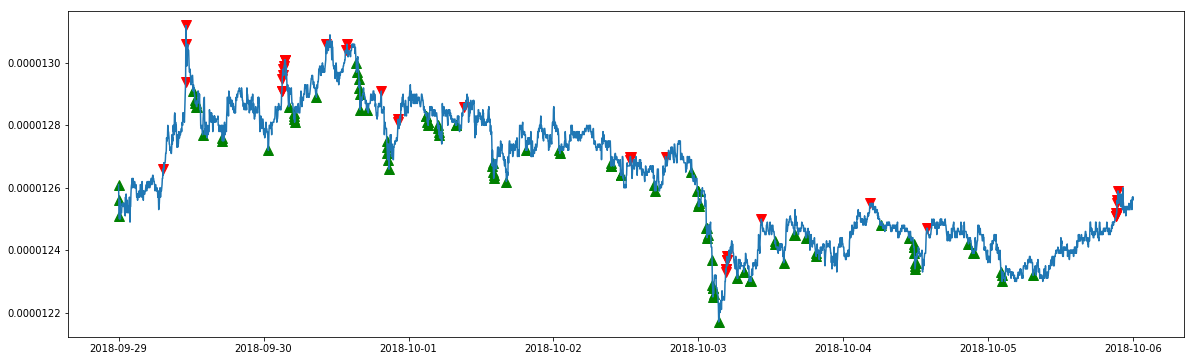

In [30]:
print(len(buys_rsi), len(buys_mfi))
buys_combine = pd.merge(buys_rsi, buys_mfi, on=['Open time'])
sells_combine = pd.merge(sells_rsi, sells_mfi, on=['Open time'])

plt.figure(figsize=(20,6))
plt.plot(buys_combine.index, data.loc[buys_combine.index]['Close'], '^', markersize=10, color='g')
plt.plot(sells_combine.index, data.loc[sells_combine.index]['Close'], 'v', markersize=10, color='r')
plt.plot(data.index, data['Close'], label='Close')
# for level in levels:
#     if level is not None:
#         ax0.axhline(y=level)


# Add a bit more space between the two plots.
fig.subplots_adjust(hspace=0.3)
plt.show()